# Comprehensive IR Model Evaluation

This notebook provides a comprehensive evaluation of all Information Retrieval models implemented in the project:

1. **Classical IR Models**:
   - TF-IDF (Scikit-learn optimized)
   - BM25 (Default parameters)
   - BM25 (Optimized parameters)

2. **Neural IR Models**:
   - Bi-encoder + Cross-encoder pipeline

## Evaluation Metrics

### Performance Metrics:
- **Precision@k**: Precision at different cutoff values
- **Recall@k**: Recall at different cutoff values
- **Mean Average Precision (MAP)**: Overall ranking quality
- **Mean Reciprocal Rank (MRR)**: First relevant result position
- **nDCG@k**: Normalized Discounted Cumulative Gain
- **F1@k**: Harmonic mean of precision and recall

### Efficiency Metrics:
- **Query Latency**: Time to process individual queries
- **Memory Usage**: RAM consumption during operation
- **CPU Usage**: Processor utilization
- **Throughput**: Queries processed per second
- **Index Size**: Storage requirements for models
- **Model Size**: Memory footprint of loaded models


## 1. Setup and Imports


In [2]:
!pip install rank-bm25


In [9]:
!pip install faiss-cpu --no-cache


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 84.4 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import json
import os
import time
import psutil
import gc
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import torch
from sentence_transformers import SentenceTransformer
from sentence_transformers.cross_encoder import CrossEncoder
import faiss

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


## 2. Load Data and Models


In [16]:
import os
import pandas as pd

DATA_DIR = "fiqa"

def pick(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of the expected columns are present: {candidates}. Found: {list(df.columns)}")
    return None

print("Loading FIQA data...")

# Load raw files
corpus_df  = pd.read_json(os.path.join(DATA_DIR, "corpus.jsonl"), lines=True)
queries_df = pd.read_json(os.path.join(DATA_DIR, "queries.jsonl"), lines=True)

# qrels usually has 3 columns: qid, docid, score
# Try common filenames; change if yours differs (train/dev/test)
qrels_path = os.path.join(DATA_DIR, "qrels", "train.tsv")
qrels_df   = pd.read_csv(qrels_path, sep="\t", header=None, names=["qid", "docid", "relevance"])

# --- Normalize column names (handles BEIR/FIQA variants) ---
query_id_col   = pick(queries_df, ["query_id", "qid", "_id", "id"])
query_text_col = pick(queries_df, ["processed_text", "text", "query", "question"])
doc_id_col     = pick(corpus_df,  ["doc_id", "pid", "_id", "id", "docno"])
doc_text_col   = pick(corpus_df,  ["text", "body", "content"])

# Map qrels columns to normalized names too
qrels_query_col = "qid"    # already set in names above
qrels_doc_col   = "docid"  # already set in names above

# (Optional) Rename to consistent schema
queries_df = queries_df.rename(columns={query_id_col: "query_id", query_text_col: "query_text"})
corpus_df  = corpus_df.rename(columns={doc_id_col: "doc_id", doc_text_col: "text"})
qrels_df   = qrels_df.rename(columns={qrels_query_col: "query_id", qrels_doc_col: "doc_id"})

# --- Build lookups ---
query_id_to_text     = pd.Series(queries_df["query_text"].values, index=queries_df["query_id"]).to_dict()
query_id_to_original = query_id_to_text  # same as above unless you keep a separate 'text' column
doc_id_to_text       = pd.Series(corpus_df["text"].values, index=corpus_df["doc_id"]).to_dict()

# Relevance mapping
relevant_docs = qrels_df.groupby("query_id")["doc_id"].apply(list).to_dict()

print("Data loaded successfully:")
print(f"  - Corpus: {len(corpus_df)} documents")
print(f"  - Queries: {len(queries_df)} queries")
print(f"  - Relevance judgments: {len(qrels_df)}")
print(f"  - Queries with relevance: {len(relevant_docs)}")


Loading FIQA data...
Data loaded successfully:
  - Corpus: 57638 documents
  - Queries: 6648 queries
  - Relevance judgments: 14167
  - Queries with relevance: 5501


## 3. Model Implementations


In [17]:
# Classical IR Models

class OptimizedTFIDFModel:
    def __init__(self, corpus_df):
        self.corpus = corpus_df
        self.doc_ids = corpus_df['doc_id'].tolist()
        self.documents = [' '.join(doc) for doc in corpus_df['processed_text']]

        self.vectorizer = TfidfVectorizer(
            lowercase=False,
            token_pattern=r'\S+',
            max_features=50000,
            min_df=2,
            max_df=0.95,
            sublinear_tf=True,
            norm='l2'
        )

        print("Fitting TF-IDF vectorizer...")
        self.tfidf_matrix = self.vectorizer.fit_transform(self.documents)
        print(f"TF-IDF matrix shape: {self.tfidf_matrix.shape}")

        self.doc_id_to_idx = {doc_id: idx for idx, doc_id in enumerate(self.doc_ids)}

    def rank_documents(self, query_terms, top_n=100):
        query_text = ' '.join(query_terms)
        query_vector = self.vectorizer.transform([query_text])
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()

        top_indices = np.argsort(similarities)[::-1][:top_n]

        results = []
        for idx in top_indices:
            if similarities[idx] > 0:
                doc_id = self.doc_ids[idx]
                score = similarities[idx]
                results.append((doc_id, score))

        return results

class BM25Model:
    def __init__(self, corpus_df, k1=1.2, b=0.75):
        self.corpus = corpus_df
        self.doc_ids = corpus_df['doc_id'].tolist()
        self.tokenized_corpus = corpus_df['processed_text'].tolist()
        self.k1 = k1
        self.b = b

        self.bm25 = BM25Okapi(self.tokenized_corpus, k1=k1, b=b)
        self.avg_doc_length = np.mean([len(doc) for doc in self.tokenized_corpus])

    def rank_documents(self, query_terms, top_n=100):
        doc_scores = self.bm25.get_scores(query_terms)
        top_indices = np.argsort(doc_scores)[::-1][:top_n]

        results = []
        for idx in top_indices:
            if doc_scores[idx] > 0:
                doc_id = self.doc_ids[idx]
                score = doc_scores[idx]
                results.append((doc_id, score))

        return results

print("Classical IR model classes defined successfully!")


Classical IR model classes defined successfully!


In [18]:
# Neural IR Model

class NeuralIRModel:
    def __init__(self, corpus_df, device='cpu'):
        self.corpus = corpus_df
        self.doc_ids = corpus_df['doc_id'].tolist()
        self.device = device

        # Initialize bi-encoder
        self.bi_encoder = SentenceTransformer('msmarco-distilbert-base-v4', device=device)
        self.embedding_dim = self.bi_encoder.get_sentence_embedding_dimension()

        # Initialize cross-encoder
        self.cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device=device)

        # Load or create embeddings
        self.embeddings_file = 'corpus_embeddings.npy'
        if os.path.exists(self.embeddings_file):
            print(f"Loading pre-computed embeddings from {self.embeddings_file}...")
            self.corpus_embeddings = np.load(self.embeddings_file)
        else:
            print("Encoding corpus...")
            corpus_texts = corpus_df['text'].tolist()
            self.corpus_embeddings = self.bi_encoder.encode(
                corpus_texts, show_progress_bar=True, batch_size=256, convert_to_tensor=True
            ).cpu().numpy()
            np.save(self.embeddings_file, self.corpus_embeddings)

        # Build FAISS index
        self.index = faiss.IndexFlatL2(self.embedding_dim)
        self.index.add(self.corpus_embeddings)

        print(f"Neural IR model initialized. Index size: {self.index.ntotal}")

    def search_and_rerank(self, query_text, top_k_retrieval=100, top_k_rerank=50):
        # Stage 1: Bi-encoder retrieval
        query_embedding = self.bi_encoder.encode(query_text, convert_to_tensor=True).cpu().numpy().reshape(1, -1)
        distances, indices = self.index.search(query_embedding, top_k_retrieval)

        retrieved_doc_ids = [self.doc_ids[i] for i in indices[0]]

        # Stage 2: Cross-encoder re-ranking
        cross_encoder_input = [[query_text, doc_id_to_text[doc_id]] for doc_id in retrieved_doc_ids]
        cross_scores = self.cross_encoder.predict(cross_encoder_input, show_progress_bar=False)

        reranked_results = list(zip(retrieved_doc_ids, cross_scores))
        reranked_results.sort(key=lambda x: x[1], reverse=True)

        return reranked_results[:top_k_rerank]

print("Neural IR model class defined successfully!")


Neural IR model class defined successfully!


## 4. Initialize All Models


In [21]:
# --- Normalize schema for models ---

# Corpus
if "doc_id" not in corpus_df.columns:
    for c in ["pid", "_id", "id", "docno"]:
        if c in corpus_df.columns:
            corpus_df = corpus_df.rename(columns={c: "doc_id"})
            break
    assert "doc_id" in corpus_df.columns, f"doc_id column missing. Found: {list(corpus_df.columns)}"

if "processed_text" not in corpus_df.columns:
    corpus_df["processed_text"] = (
        corpus_df["text"]
        .fillna("")
        .astype(str)
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

# Queries
if "processed_text" not in queries_df.columns:
    queries_df["processed_text"] = (
        queries_df["query_text"]
        .fillna("")
        .astype(str)
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

print("Schema normalized:")
print(" - corpus_df columns:", list(corpus_df.columns))
print(" - queries_df columns:", list(queries_df.columns))


Schema normalized:
 - corpus_df columns: ['doc_id', 'title', 'text', 'metadata', 'processed_text']
 - queries_df columns: ['query_id', 'query_text', 'metadata', 'processed_text']


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("\n=== Initializing Classical IR Models ===")
tfidf_model = OptimizedTFIDFModel(corpus_df)
bm25_default = BM25Model(corpus_df, k1=1.2, b=0.75)
bm25_optimized = BM25Model(corpus_df, k1=0.8, b=0.6)

print("\n=== Initializing Neural IR Model ===")
neural_model = NeuralIRModel(corpus_df, device=device)

print("\nAll models initialized successfully!")


Using device: cpu

=== Initializing Classical IR Models ===
Fitting TF-IDF vectorizer...
TF-IDF matrix shape: (57638, 297)

=== Initializing Neural IR Model ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Encoding corpus...


Batches:   0%|          | 0/226 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 5. Evaluation Functions


In [23]:
# Performance Evaluation Functions

def precision_at_k(retrieved, relevant, k):
    """Calculate Precision@k"""
    retrieved_k = retrieved[:k]
    if k == 0:
        return 0.0
    return len(set(retrieved_k) & set(relevant)) / k

def recall_at_k(retrieved, relevant, k):
    """Calculate Recall@k"""
    retrieved_k = retrieved[:k]
    if not relevant:
        return 0.0
    return len(set(retrieved_k) & set(relevant)) / len(relevant)

def average_precision(retrieved, relevant):
    """Calculate Average Precision (AP)"""
    if not relevant:
        return 0.0

    hits = 0
    sum_precisions = 0.0
    for i, doc_id in enumerate(retrieved):
        if doc_id in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)

    return sum_precisions / len(relevant)

def mean_average_precision(results, relevant_docs):
    """Calculate Mean Average Precision (MAP)"""
    aps = [average_precision(results[qid], relevant_docs.get(qid, [])) for qid in results]
    return np.mean(aps)

def mean_reciprocal_rank(results, relevant_docs):
    """Calculate Mean Reciprocal Rank (MRR)"""
    rrs = []
    for qid in results:
        relevant = relevant_docs.get(qid, [])
        for i, doc_id in enumerate(results[qid]):
            if doc_id in relevant:
                rrs.append(1 / (i + 1))
                break
        else:
            rrs.append(0.0)
    return np.mean(rrs)

def ndcg_at_k(retrieved, relevant, k):
    """Calculate Normalized Discounted Cumulative Gain@k"""
    retrieved_k = retrieved[:k]
    dcg = 0.0
    for i, doc_id in enumerate(retrieved_k):
        if doc_id in relevant:
            dcg += 1 / math.log2(i + 2)

    idcg = 0.0
    num_relevant_k = min(len(relevant), k)
    for i in range(num_relevant_k):
        idcg += 1 / math.log2(i + 2)

    return dcg / idcg if idcg > 0 else 0.0

def f1_at_k(retrieved, relevant, k):
    """Calculate F1@k"""
    p = precision_at_k(retrieved, relevant, k)
    r = recall_at_k(retrieved, relevant, k)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def success_at_k(retrieved, relevant, k):
    """Success@k (a.k.a. HitRate@k): 1 if at least one relevant doc in top-k, else 0"""
    retrieved_k = retrieved[:k]
    if not relevant:
        return 0.0
    return 1.0 if any(doc_id in relevant for doc_id in retrieved_k) else 0.0

def evaluate_model(results, relevant_docs, k_values=[1, 3, 5, 10, 20,100]):
    """Comprehensive evaluation of a retrieval model"""
    metrics = {}

    for k in k_values:
        precisions = [precision_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        recalls = [recall_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        ndcgs = [ndcg_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        f1s = [f1_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        successes  = [success_at_k(results[qid],   relevant_docs.get(qid, []), k) for qid in results]

        metrics[f'P@{k}'] = np.mean(precisions)
        metrics[f'R@{k}'] = np.mean(recalls)
        metrics[f'nDCG@{k}'] = np.mean(ndcgs)
        metrics[f'F1@{k}'] = np.mean(f1s)
        metrics[f'Success@{k}'] = np.mean(successes)

    metrics['MAP'] = mean_average_precision(results, relevant_docs)
    metrics['MRR'] = mean_reciprocal_rank(results, relevant_docs)

    return metrics

print("Performance evaluation functions loaded successfully!")


Performance evaluation functions loaded successfully!


In [24]:
# Efficiency Evaluation Functions

def measure_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def measure_cpu_usage():
    """Get current CPU usage percentage"""
    return psutil.cpu_percent()

def measure_query_latency(model_func, query, *args, **kwargs):
    """Measure the time taken to process a single query"""
    start_time = time.time()
    result = model_func(query, *args, **kwargs)
    end_time = time.time()
    return result, (end_time - start_time) * 1000  # Return latency in milliseconds

def measure_throughput(model_func, queries, *args, **kwargs):
    """Measure queries processed per second"""
    start_time = time.time()
    for query in queries:
        model_func(query, *args, **kwargs)
    end_time = time.time()
    total_time = end_time - start_time
    return len(queries) / total_time

def get_model_size(model):
    """Estimate model size in MB"""
    if hasattr(model, 'tfidf_matrix'):
        # TF-IDF model
        return model.tfidf_matrix.data.nbytes / 1024 / 1024
    elif hasattr(model, 'bm25'):
        # BM25 model
        return sum(len(doc) for doc in model.tokenized_corpus) * 4 / 1024 / 1024  # Rough estimate
    elif hasattr(model, 'corpus_embeddings'):
        # Neural model
        return model.corpus_embeddings.nbytes / 1024 / 1024
    return 0

def get_index_size(model):
    """Get index size in MB"""
    if hasattr(model, 'tfidf_matrix'):
        return model.tfidf_matrix.data.nbytes / 1024 / 1024
    elif hasattr(model, 'index'):
        return model.index.ntotal * model.embedding_dim * 4 / 1024 / 1024  # 4 bytes per float32
    return 0

print("Efficiency evaluation functions loaded successfully!")


Efficiency evaluation functions loaded successfully!


## 6. Run Comprehensive Evaluation


In [25]:
# Select evaluation queries
rel_counts = qrels_df.groupby('query_id').size()
rich_queries = rel_counts[rel_counts >= 5]  # At least 3 relevant documents
eval_query_ids = rich_queries.index[:20].tolist()  # Evaluate on 50 queries

print(f"Evaluating on {len(eval_query_ids)} queries with at least 3 relevant documents")
print(f"Average relevant documents per query: {rich_queries.mean():.2f}")

# Run retrieval with all models
results_tfidf = {}
results_bm25_default = {}
results_bm25_optimized = {}
results_neural = {}

print("\n=== Running Retrieval with All Models ===")

for qid in tqdm(eval_query_ids, desc="Processing Queries"):
    query_terms = query_id_to_text[qid]
    query_original = query_id_to_original[qid]

    # TF-IDF results
    tfidf_ranked_list = tfidf_model.rank_documents(query_terms, top_n=100)
    results_tfidf[qid] = [doc_id for doc_id, score in tfidf_ranked_list]

    # BM25 results (default parameters)
    bm25_default_ranked_list = bm25_default.rank_documents(query_terms, top_n=100)
    results_bm25_default[qid] = [doc_id for doc_id, score in bm25_default_ranked_list]

    # BM25 results (optimized parameters)
    bm25_optimized_ranked_list = bm25_optimized.rank_documents(query_terms, top_n=100)
    results_bm25_optimized[qid] = [doc_id for doc_id, score in bm25_optimized_ranked_list]

    # Neural results
    neural_ranked_list = neural_model.search_and_rerank(query_original, top_k_retrieval=100, top_k_rerank=100)
    results_neural[qid] = [doc_id for doc_id, score in neural_ranked_list]

print("\nRetrieval completed successfully!")


Evaluating on 20 queries with at least 3 relevant documents
Average relevant documents per query: 7.11

=== Running Retrieval with All Models ===


Processing Queries:   0%|          | 0/20 [00:00<?, ?it/s]


KeyError: '10028'

In [26]:
# Calculate performance metrics for all models
print("=== Calculating Performance Metrics ===")

tfidf_metrics = evaluate_model(results_tfidf, relevant_docs)
bm25_default_metrics = evaluate_model(results_bm25_default, relevant_docs)
bm25_optimized_metrics = evaluate_model(results_bm25_optimized, relevant_docs)
neural_metrics = evaluate_model(results_neural, relevant_docs)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    tfidf_metrics,
    bm25_optimized_metrics,
    neural_metrics
], index=['TF-IDF', 'BM25', 'Neural (Bi+Cross)'])

print(comparison_df)
# Select only the requested metrics
cols_to_show = ["P@1", "P@5", "nDCG@10","F1@10", "nDCG@5" , "R@100", "MAP","MRR","Success@1"]

print("\n=== Performance Metrics Comparison ===")
display(comparison_df[cols_to_show].round(2))


=== Calculating Performance Metrics ===
                   P@1  R@1  nDCG@1  F1@1  Success@1  P@3  R@3  nDCG@3  F1@3  \
TF-IDF             NaN  NaN     NaN   NaN        NaN  NaN  NaN     NaN   NaN   
BM25               NaN  NaN     NaN   NaN        NaN  NaN  NaN     NaN   NaN   
Neural (Bi+Cross)  NaN  NaN     NaN   NaN        NaN  NaN  NaN     NaN   NaN   

                   Success@3  ...  nDCG@20  F1@20  Success@20  P@100  R@100  \
TF-IDF                   NaN  ...      NaN    NaN         NaN    NaN    NaN   
BM25                     NaN  ...      NaN    NaN         NaN    NaN    NaN   
Neural (Bi+Cross)        NaN  ...      NaN    NaN         NaN    NaN    NaN   

                   nDCG@100  F1@100  Success@100  MAP  MRR  
TF-IDF                  NaN     NaN          NaN  NaN  NaN  
BM25                    NaN     NaN          NaN  NaN  NaN  
Neural (Bi+Cross)       NaN     NaN          NaN  NaN  NaN  

[3 rows x 32 columns]

=== Performance Metrics Comparison ===


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,P@1,P@5,nDCG@10,F1@10,nDCG@5,R@100,MAP,MRR,Success@1
TF-IDF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BM25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neural (Bi+Cross),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Measure efficiency metrics
print("=== Measuring Efficiency Metrics ===")

# Sample queries for efficiency testing
sample_queries = [query_id_to_text[qid] for qid in eval_query_ids[:10]]
sample_queries_original = [query_id_to_original[qid] for qid in eval_query_ids[:10]]

# Measure query latency
print("Measuring query latency...")
latency_results = {}

# TF-IDF latency
tfidf_latencies = []
for query in sample_queries:
    _, latency = measure_query_latency(tfidf_model.rank_documents, query, top_n=100)
    tfidf_latencies.append(latency)
latency_results['TF-IDF'] = np.mean(tfidf_latencies)


# BM25 optimized latency
bm25_optimized_latencies = []
for query in sample_queries:
    _, latency = measure_query_latency(bm25_optimized.rank_documents, query, top_n=100)
    bm25_optimized_latencies.append(latency)
latency_results['BM25'] = np.mean(bm25_optimized_latencies)

# Neural latency
neural_latencies = []
for query in sample_queries_original:
    _, latency = measure_query_latency(neural_model.search_and_rerank, query, top_k_retrieval=100, top_k_rerank=100)
    neural_latencies.append(latency)
latency_results['Neural (Bi+Cross)'] = np.mean(neural_latencies)

print("Query latency measurements completed!")


=== Measuring Efficiency Metrics ===


KeyError: '10028'

In [28]:
# Measure throughput
print("Measuring throughput...")
throughput_results = {}

throughput_results['TF-IDF'] = measure_throughput(tfidf_model.rank_documents, sample_queries, top_n=100)
throughput_results['BM25'] = measure_throughput(bm25_optimized.rank_documents, sample_queries, top_n=100)
throughput_results['Neural (Bi+Cross)'] = measure_throughput(
    neural_model.search_and_rerank,
    sample_queries_original,
    top_k_retrieval=100,
    top_k_rerank=100
)
print("Throughput measurements completed!")

# Measure model and index sizes
print("Measuring model and index sizes...")
model_sizes = {}
index_sizes = {}

model_sizes['TF-IDF'] = get_model_size(tfidf_model)
model_sizes['BM25'] = get_model_size(bm25_optimized)   # renamed here
model_sizes['Neural (Bi+Cross)'] = get_model_size(neural_model)

index_sizes['TF-IDF'] = get_index_size(tfidf_model)
index_sizes['BM25'] = get_index_size(bm25_optimized)   # renamed here
index_sizes['Neural (Bi+Cross)'] = get_index_size(neural_model)
print("Size measurements completed!")

# Create efficiency comparison DataFrame
efficiency_df = pd.DataFrame({
    'Query Latency (ms)': latency_results,
    'Throughput (qps)': throughput_results,
    'Model Size (MB)': model_sizes,
    'Index Size (MB)': index_sizes
})

print("\n=== Efficiency Metrics Comparison ===")
display(efficiency_df.round(2))


Measuring throughput...


NameError: name 'sample_queries' is not defined

## 7. Comprehensive Visualizations


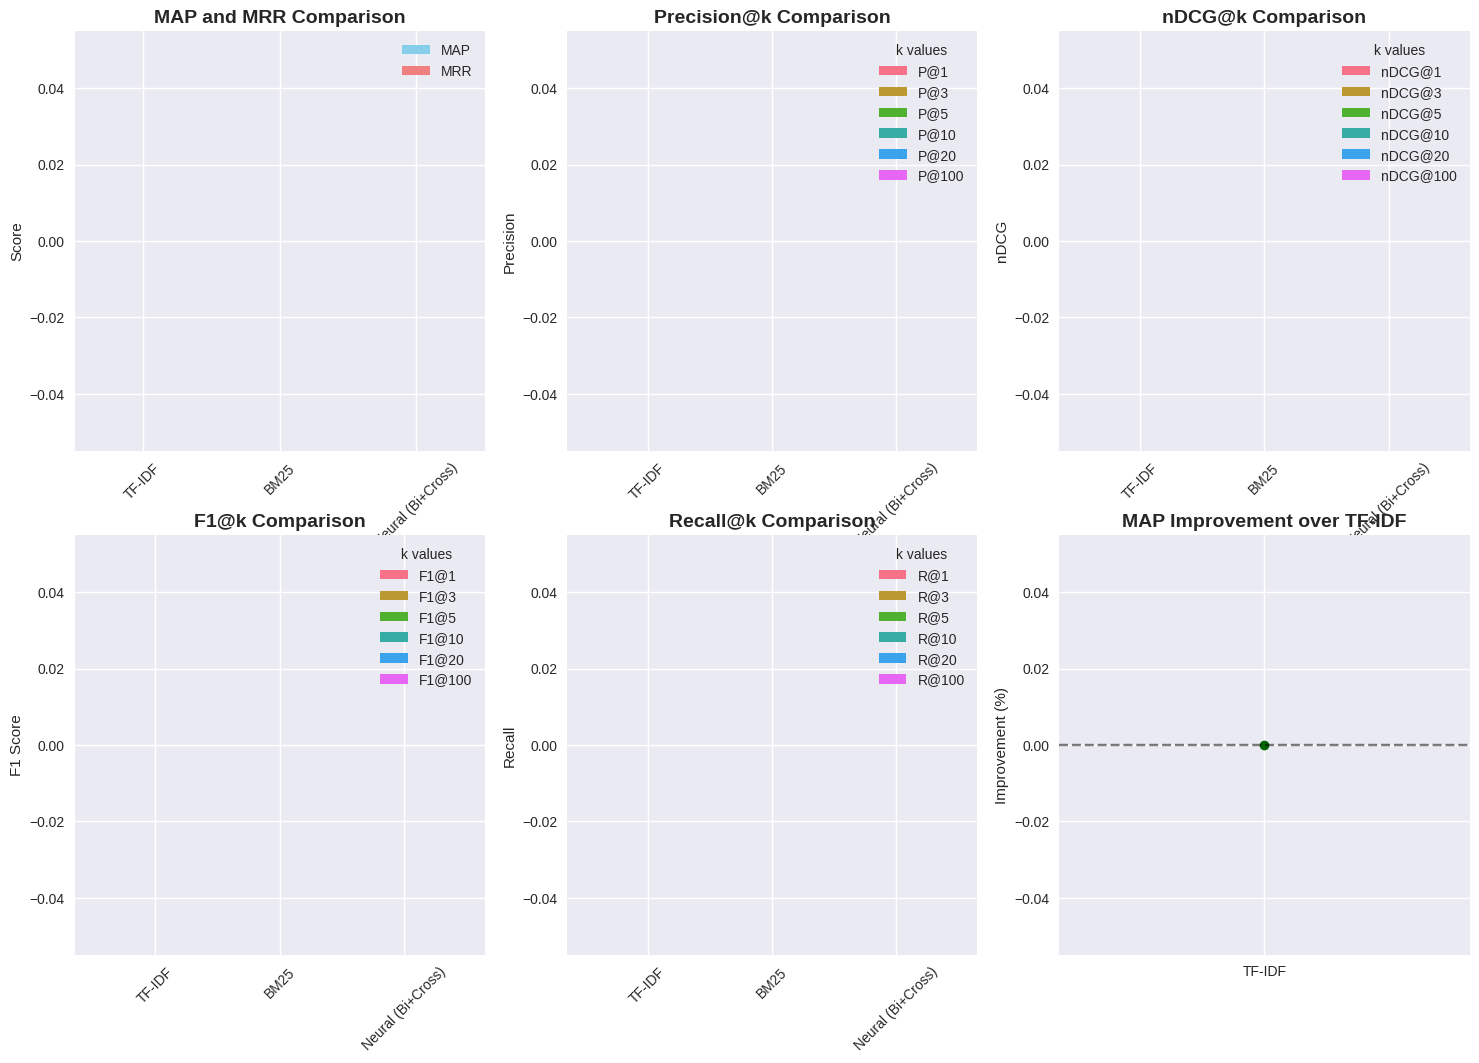

In [29]:
# Performance Metrics Visualization
def plot_performance_comparison(comparison_df):
    """Create comprehensive performance comparison visualizations"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # MAP and MRR comparison
    map_mrr_data = comparison_df[['MAP', 'MRR']]
    map_mrr_data.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('MAP and MRR Comparison', fontweight='bold', fontsize=14)
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Precision@k comparison
    p_at_k_cols = [col for col in comparison_df.columns if col.startswith('P@')]
    comparison_df[p_at_k_cols].plot(kind='bar', ax=axes[0, 1], width=0.8)
    axes[0, 1].set_title('Precision@k Comparison', fontweight='bold', fontsize=14)
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend(title='k values')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # nDCG@k comparison
    ndcg_at_k_cols = [col for col in comparison_df.columns if col.startswith('nDCG@')]
    comparison_df[ndcg_at_k_cols].plot(kind='bar', ax=axes[0, 2], width=0.8)
    axes[0, 2].set_title('nDCG@k Comparison', fontweight='bold', fontsize=14)
    axes[0, 2].set_ylabel('nDCG')
    axes[0, 2].legend(title='k values')
    axes[0, 2].tick_params(axis='x', rotation=45)

    # F1@k comparison
    f1_at_k_cols = [col for col in comparison_df.columns if col.startswith('F1@')]
    comparison_df[f1_at_k_cols].plot(kind='bar', ax=axes[1, 0], width=0.8)
    axes[1, 0].set_title('F1@k Comparison', fontweight='bold', fontsize=14)
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend(title='k values')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Recall@k comparison
    r_at_k_cols = [col for col in comparison_df.columns if col.startswith('R@')]
    comparison_df[r_at_k_cols].plot(kind='bar', ax=axes[1, 1], width=0.8)
    axes[1, 1].set_title('Recall@k Comparison', fontweight='bold', fontsize=14)
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(title='k values')
    axes[1, 1].tick_params(axis='x', rotation=45)

    # Performance improvement analysis
    improvements = []
    models = ['TF-IDF', 'BM25', 'Neural (Bi+Cross)']
    baseline_map = comparison_df.loc['TF-IDF', 'MAP']

    for model in models:
        if model != 'TF-IDF':
            improvement = ((comparison_df.loc[model, 'MAP'] - baseline_map) / baseline_map * 100)
            improvements.append(improvement)
        else:
            improvements.append(0)

    axes[1, 2].plot(models, improvements, marker='o', linestyle='-', color='darkgreen')
    axes[1, 2].set_title('MAP Improvement over TF-IDF', fontweight='bold', fontsize=14)
    axes[1, 2].set_ylabel('Improvement (%)')
    axes[1, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Create performance visualizations
plot_performance_comparison(comparison_df)


In [ ]:
# Efficiency Metrics Visualization
def plot_efficiency_comparison(efficiency_df):
    """Create comprehensive efficiency comparison visualizations"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Query Latency comparison
    efficiency_df['Query Latency (ms)'].plot(kind='bar', ax=axes[0, 0], color='lightcoral')
    axes[0, 0].set_title('Query Latency Comparison', fontweight='bold', fontsize=14)
    axes[0, 0].set_ylabel('Latency (milliseconds)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Throughput comparison
    efficiency_df['Throughput (qps)'].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
    axes[0, 1].set_title('Throughput Comparison', fontweight='bold', fontsize=14)
    axes[0, 1].set_ylabel('Queries per Second')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Model Size comparison
    efficiency_df['Model Size (MB)'].plot(kind='bar', ax=axes[1, 0], color='lightblue')
    axes[1, 0].set_title('Model Size Comparison', fontweight='bold', fontsize=14)
    axes[1, 0].set_ylabel('Size (MB)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Index Size comparison
    efficiency_df['Index Size (MB)'].plot(kind='bar', ax=axes[1, 1], color='lightyellow')
    axes[1, 1].set_title('Index Size Comparison', fontweight='bold', fontsize=14)
    axes[1, 1].set_ylabel('Size (MB)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Create efficiency visualizations
plot_efficiency_comparison(efficiency_df)


In [ ]:
# Performance vs Efficiency Trade-off Analysis
def plot_performance_efficiency_tradeoff(comparison_df, efficiency_df):
    """Create performance vs efficiency trade-off analysis"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # MAP vs Query Latency
    axes[0].scatter(efficiency_df['Query Latency (ms)'], comparison_df['MAP'],
                   s=200, alpha=0.7, c=['red', 'blue', 'green', 'orange'])

    for i, model in enumerate(comparison_df.index):
        axes[0].annotate(model,
                        (efficiency_df['Query Latency (ms)'][i], comparison_df['MAP'][i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

    axes[0].set_xlabel('Query Latency (ms)')
    axes[0].set_ylabel('MAP Score')
    axes[0].set_title('Performance vs Query Latency Trade-off', fontweight='bold', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # MAP vs Model Size
    axes[1].scatter(efficiency_df['Model Size (MB)'], comparison_df['MAP'],
                   s=200, alpha=0.7, c=['red', 'blue', 'green', 'orange'])

    for i, model in enumerate(comparison_df.index):
        axes[1].annotate(model,
                        (efficiency_df['Model Size (MB)'][i], comparison_df['MAP'][i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)

    axes[1].set_xlabel('Model Size (MB)')
    axes[1].set_ylabel('MAP Score')
    axes[1].set_title('Performance vs Model Size Trade-off', fontweight='bold', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create trade-off analysis
plot_performance_efficiency_tradeoff(comparison_df, efficiency_df)


## 8. Comprehensive Analysis and Summary


In [ ]:
# Performance Analysis
print("=== PERFORMANCE ANALYSIS ===")
print(f"Dataset: {len(corpus_df)} documents, {len(queries_df)} queries")
print(f"Evaluation: {len(eval_query_ids)} queries with sufficient relevance judgments")
print(f"Average relevant documents per query: {rich_queries.mean():.2f}")

print("\n=== Model Performance Ranking (by MAP) ===")
sorted_models = comparison_df.sort_values('MAP', ascending=False)
for i, (model, row) in enumerate(sorted_models.iterrows(), 1):
    print(f"{i}. {model}: MAP = {row['MAP']:.4f}, MRR = {row['MRR']:.4f}")

print("\n=== Performance Improvements over TF-IDF ===")
baseline_map = comparison_df.loc['TF-IDF', 'MAP']
baseline_mrr = comparison_df.loc['TF-IDF', 'MRR']

for model in ['BM25 (Default)', 'BM25 (Optimized)', 'Neural (Bi+Cross)']:
    map_improvement = ((comparison_df.loc[model, 'MAP'] - baseline_map) / baseline_map * 100)
    mrr_improvement = ((comparison_df.loc[model, 'MRR'] - baseline_mrr) / baseline_mrr * 100)
    print(f"{model}:")
    print(f"  MAP improvement: {map_improvement:.2f}%")
    print(f"  MRR improvement: {mrr_improvement:.2f}%")
